In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

import warnings
warnings.filterwarnings('ignore')

## [DSO] Machine Learning Seminar Vol.5
2020-04-xx  
SKUE

In [2]:
Image(url="https://image.yodobashi.com/product/100/000/009/002/935/105/100000009002935105_10204.jpg")

## Breast Cancer Wisconsinデータセット

In [4]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [8]:
display(df.shape)
display(df.info())

(569, 32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
0     569 non-null int64
1     569 non-null object
2     569 non-null float64
3     569 non-null float64
4     569 non-null float64
5     569 non-null float64
6     569 non-null float64
7     569 non-null float64
8     569 non-null float64
9     569 non-null float64
10    569 non-null float64
11    569 non-null float64
12    569 non-null float64
13    569 non-null float64
14    569 non-null float64
15    569 non-null float64
16    569 non-null float64
17    569 non-null float64
18    569 non-null float64
19    569 non-null float64
20    569 non-null float64
21    569 non-null float64
22    569 non-null float64
23    569 non-null float64
24    569 non-null float64
25    569 non-null float64
26    569 non-null float64
27    569 non-null float64
28    569 non-null float64
29    569 non-null float64
30    569 non-null float64
31    569 non-null float64
dtypes: float64(30), int64(1), obj

None

In [11]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [12]:
le.transform(['M', 'B'])

array([1, 0])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                                                       stratify=y, random_state=1)

## パイプラインで変換器と推定器を結合する

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# 連結する処理としてスケーリング、主成分分析、ロジスティック回帰を指定
pipe_lr = make_pipeline(StandardScaler(),
                                           PCA(n_components=2),
                                           LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


## k分割交差検証を使ったモデルの性能の評価

### ホールド・アウト法
+ 効果的な方法は、データをトレーニングデータセット、検証データセット、テストデータセットの3つに分割すること

### k分割交差検証
+ 非復元抽出を用いて、トレーニングデータセットをランダムにk個に分割する。
 + そのうちk-1個をモデルのトレーニングに使用し、1個を性能の評価に使用する。
  + この手順をk回繰り返すことでk個のモデルを取得し、性能を推定する。

In [19]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# 分割元データ、分割数、乱数生成器の状態を指定し、層化k分割交差検証イテレータを表すStratifiedKFoldクラスのインスタンス化
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)
scores = []

# イテレータのインデックスと要素をループ処理：（上から順に）
# データをモデルに適合
# テストデータの正解率を算出
# リストに正解率を追加
# 分割の番号、0 以上の要素数、正解率を出力
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [20]:
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


CV accuracy: 0.950 +/- 0.014


In [22]:
from sklearn.model_selection import cross_val_score

# 交差検証のcross_val_score関数でモデルの正解率を算出
# 推定器estimator、トレーニングデータX、予測値y、分割数cv、CPU数n_jobsを指定
scores = cross_val_score(estimator=pipe_lr,
                                              X=X_train, y=y_train,
                                              cv=10, n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


## 学習曲線と検証曲線によるアルゴリズムの診断

### 学習曲線を使ってバイアスとバリアンスの問題を診断する

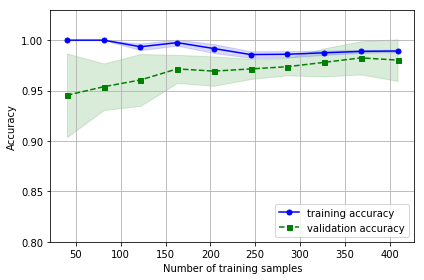

In [31]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
                                           LogisticRegression(penalty='l2', random_state=1))

# learning_curve関数で交差検証による正解率を算出
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                                                                 X=X_train,
                                                                                                 y=y_train,
                                                                                                 train_sizes=np.linspace(0.1, 1.0, 10),
                                                                                                 cv=10,
                                                                                                 n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
              color='blue', marker='o',
              markersize=5,
              label='training accuracy')

# fill_between関数で平均±標準偏差の幅を塗りつぶす
# トレーニングデータのサイズtrain_sizes、透明度alpha、カラー'blue'を引数に指定
plt.fill_between(train_sizes,
                             train_mean + train_std,
                             train_mean - train_std,
                             alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
                color='green',
                linestyle='--',
                marker='s', markersize=5,
                label='validation accuracy')
plt.fill_between(train_sizes,
                             test_mean + test_std,
                             test_mean - test_std,
                             alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

### 検証曲線を使って過学習と学習不足を明らかにする

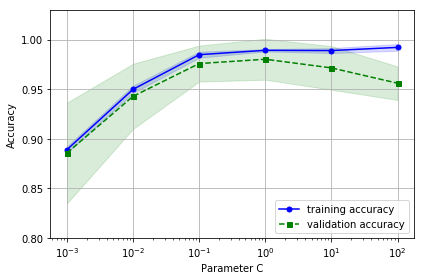

In [33]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0 , 10.0, 100.0]

# validation_curve関数によるモデルのパラメータを変化させ、交差検証による正解率を算出
# clf__CはLogisticRegressionオブジェクトのパラメータ
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                                                                X=X_train,
                                                                                y=y_train,
                                                                                param_name='logisticregression__C',
                                                                                param_range=param_range,
                                                                                cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,
              color='blue', marker='o',
              markersize=5,
              label='training accuracy')

# fill_between関数で平均±標準偏差の幅を塗りつぶす
# param_range、透明度alpha、カラー'blue'を引数に指定
plt.fill_between(param_range,
                             train_mean + train_std,
                             train_mean - train_std,
                             alpha=0.15, color='blue')
plt.plot(param_range, test_mean,
                color='green',
                linestyle='--',
                marker='s', markersize=5,
                label='validation accuracy')
plt.fill_between(param_range,
                             test_mean + test_std,
                             test_mean - test_std,
                             alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

## グリッドサーチによる機械学習モデルのチューニング

### グリッドサーチを使ったハイパーパラメータのチューニング

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(),
                                               SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
                          {'svc__C': param_range, 'svc__gamma': param_range,
                            'svc__kernel': ['rbf']}]

# ハイパーパラメータ値のリストparam_gridを指定し、グリッドサーチを行うGridSearchCVクラスをインスタンス化
gs = GridSearchCV(estimator=pipe_svc,
                                  param_grid=param_grid,
                                  scoring='accuracy',
                                  cv=10,
                                  n_jobs=-1)
gs = gs.fit(X_train, y_train)

# モデルの最良スコアを出力
print(gs.best_score_)

# 最良スコアとなるパラメータ値を出力
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__kernel': 'rbf', 'svc__gamma': 0.001}


In [35]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


### 入れ子式の交差検証によるアルゴリズムの選択

In [36]:
gs = GridSearchCV(estimator=pipe_svc,
                                  param_grid=param_grid,
                                  scoring='accuracy',
                                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [37]:
from sklearn.tree import DecisionTreeClassifier
# ハイパーパラメータ値として決定木の深さパラメータを指定し、グリッドサーチを行うGridSearchCVクラスをインスタンス化
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                                  param_grid=[{'max_depth':[1, 2, 3, 4, 5, 6, 7, None]}],
                                  scoring='accuracy',
                                  cv=2)
scores = cross_val_score(gs,
                                              X_train,
                                              y_train,
                                              scoring='accuracy',
                                              cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.934 +/- 0.016
